In [1]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} tqdm numpy scipy 


Solving environment: done

# All requested packages already installed.



In [2]:
%matplotlib inline
import numpy as  np   
import scipy as sp
import time
import math
from pylab import *
from scipy.integrate import quad 
from matplotlib import animation, rc
rc('animation', html='html5');
from tqdm import tqdm

In [3]:
def createGraph(n):
    if (n<1):
        return np.array([])
    return np.zeros((n, n))

def createPos(n, d):
    if (n<1 or d<1):
        return np.array([])
    return np.zeros((n, d))

def setVertex(A , i ,j):
    A[i, j] = 1
    A[j, i] = 1

def ringInit2D(A, pA):
    for i in range(N):
        p = N*np.exp(i * 2.*np.pi*1.j/N)
        pA[i, :] = [np.real(p), np.imag(p)]
        
def createPosRandom(n, d):
    return np.random.uniform(-n/2., n/2., (n, d))

def createPointRandom(n, d):
    return np.random.uniform(-n/2., n/2., d)

def plotGraph(A, pA):
    # Plot vertices
    plot(pA[:, 0], pA[:, 1], 'ro')
    for i in range(N):
        annotate(str(i), xy=(pA[i, 0], pA[i, 1]), xytext=(pA[i, 0], pA[i, 1])) 
    axis('equal')
    
    # Plot edges
    for i in range(N):
        for j in arange(i + 1, N):
            if ( A[i, j] == 1 ):
                plot([ pA[i, 0], pA[j, 0] ], [ pA[i, 1], pA[j, 1] ], 'black')

def plotGraphReordered(A, pA, permutAB):
    # Plot vertices
    plot(pA[:, 0], pA[:, 1], 'ro')
    for i in range(N):
        annotate(str(permutAB[i]), xy=(pA[i, 0], pA[i, 1]), xytext=(pA[i, 0], pA[i, 1])) 
    axis('equal')
    
    # Plot edges
    for i in range(N):
        for j in arange(i + 1, N):
            if ( A[i, j] == 1 ):
                plot([ pA[i, 0], pA[j, 0] ], [ pA[i, 1], pA[j, 1] ], 'black')
    
                
def genRingGraphClose():
    A = createGraph(N)
    for i in range(N):
        setVertex(A, i, (i+1)%N)
    return A

def genRingGraphOpen():
    A = createGraph(N)
    for i in range(N-1):
        setVertex(A, i, i+1)
    return A
                
def genRandomGraph():
    A = createGraph(N)
    
    for i in range(N):
        # select one vertices and connect them
        for k in range(np.random.randint(int(5))):
            j = np.random.randint(0, N)
            setVertex(A, i, j)
    return A

def isConnected(A):
    if( dGM(A).max() < N):
        return True
    return False

def genRandomGraphConnected():
    A = genRandomGraph()
    
    while( not isConnected(A)):
        A = genRandomGraph()
    return A

def showDist(A, pA):
    for i in range(N):
        for j in arange(i, N):
            print("Distance ", i, "-", j, " :", dG(A, i, j), " _ ", np.linalg.norm(pA[i, :] - pA[j, :]))

In [4]:
def dG(A, i ,j):
    # La distance max sur un graph a N points est N-1
    # Donc si on parcours le graph N fois est que l'on arrive pas à un point donné dG=inf
    if ( i== j):
        return 0
    
    for k in arange(1, N + 1):
        if ( np.linalg.matrix_power(A,k)[i, j] > 0 ):
            return k
    return np.inf

def dGM(A):
    M = np.zeros((N, N))
    
    for i in range(N):
        for j in arange(i + 1, N):
            M[i, j] = dG(A, i, j)
            M[j, i] = M[i, j]
    return M

In [5]:
def S(pA, dA):
    s = 0.
    for i in range(N):
        for j in arange(i+1, N):
            s += (dA[i, j] - np.linalg.norm(pA[i, :] - pA[j, :]))**2
    return s
    

In [15]:
def opti1(A, n, d, Nk):
    pA = createPos(n, d)
    dA = dGM(A)
    ringInit2D(A, pA)
    
    
    for k in tqdm(range(Nk)):
        val = S(pA, dA)
        i = np.random.randint(0, n)
        x = np.random.uniform(-1,1)
        y = np.random.uniform(-1,1)
        pA[i, :] += [x, y]
        
        if(val < S(pA, dA)):
            pA[i, :] -= [x, y]
    plotGraph(A, pA)
    return pA

def opti2(A, n, d, Nk):
    pA = createPos(n, d)
    dA = dGM(A)
    ringInit2D(A, pA)
    
    
    
    for k in tqdm(range(Nk)):
        val = S(pA, dA)
        i = np.random.randint(0, n)
        x = Nk * np.random.uniform(-1, 1)/(k + 1)**2
        y = Nk * np.random.uniform(-1, 1)/(k + 1)**2
        pA[i, :] += [x, y]
        
        if(val < S(pA, dA)):
            pA[i, :] -= [x, y]
    plotGraph(A, pA)
    return pA

def opti2_GA(A, n, d, Nk, pA):
    dA = dGM(A)
    for k in range(Nk):
        val = S(pA, dA)
        i = np.random.randint(0, n)
        x = Nk * np.random.uniform(-1, 1)/(k + 1)**2
        y = Nk * np.random.uniform(-1, 1)/(k + 1)**2
        pA[i, :] += [x, y]
        
        if(val < S(pA, dA)):
            pA[i, :] -= [x, y]
    return pA

def opti_localSearch(A, n, d, Nk):
    dA = dGM(A)
    pAbest = createPos(n, d)
    pA = createPos(n, d)
    vbest = S(pA, dA)
    for k in tqdm(range(Nk)):
        pA[0, :] = [0, 0]
        for i in np.arange(1,N):
            
            theta = np.random.uniform(0, 2.*pi)
            r = dA[0, i]
            #r = np.random.uniform(0, dA[0, i])
            pA[i, :] = [r * cos(theta), r * sin(theta)]
            val = S(pA, dA)
        if(vbest > val):
            val , vbest = vbest, val
            pAbest, pA = pA, pAbest
    plotGraph(A, pAbest)
    return pAbest

def opti_localSearchRefined(A, n, d, Nk):
    dA = dGM(A)
    pAbest = createPos(n, d)
    #init pAbest with a guess
    pAbest[0, :] = [0, 0]
    for i in np.arange(1,N):
            theta = np.random.uniform(0, 2.*pi)
            r = dA[0, i]
            #r = np.random.uniform(0, dA[0, i])
            pAbest[i, :] = [r * cos(theta), r * sin(theta)]
    
    pA = createPos(n, d)
    vbest = S(pAbest, dA)
    for k in tqdm(range(Nk)):
        pA = np.array(pAbest)
        
        i = np.random.randint(1,N)
        theta = np.random.uniform(0, 2.*pi)
        r = dA[0, i]
        #r = np.random.uniform(0, dA[0, i])
        pA[i, :] = [r * cos(theta), r * sin(theta)]
        
        val = S(pA, dA)
        if(vbest > val):
            val , vbest = vbest, val
            pAbest, pA = pA, pAbest
    plotGraph(A, pAbest)
    return pAbest
    

In [7]:
def findBestIndiv(pop):
    bi = 0
    bs = S(pop[0], dA)
    for i in range(1, len(pop)):
        tmp = S(pop[i], dA)
        if (tmp < bs):
            bs= tmp
            bi = i
    return bi
        

In [23]:
N = 20
D = 2

In [24]:
A = genRandomGraphConnected()
dA = dGM(A)
pA = createPosRandom(N, D)
ringInit2D(A, pA)

In [25]:
# Reorder point in the graph using the graph distance
# We use the first point on the graph as origin
B = createGraph(N)
nbPtsInserted = 1
# A[bijectAB[i]] == B[i]
bijectAB = [0]
pL = [i for i in np.arange(1, N)]
for d in np.arange(1, N):
    # d distance on the graph
    for p in pL:
        if (dG(A, 0, p) == d):
            bijectAB.append(p)
            for pi in range(len(bijectAB)):
                if(A[bijectAB[pi], p] == 1):
                    setVertex(B, len(bijectAB) - 1, pi)
            
            
            nbPtsInserted += 1
dB = dGM(B)
            

In [26]:
dB

array([[0., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3.,
        3., 3., 3., 4.],
       [1., 0., 2., 1., 1., 2., 1., 2., 2., 3., 2., 4., 3., 2., 2., 3.,
        2., 2., 2., 3.],
       [1., 2., 0., 2., 3., 3., 2., 1., 3., 1., 3., 2., 4., 3., 2., 2.,
        4., 3., 4., 4.],
       [1., 1., 2., 0., 2., 1., 1., 2., 1., 3., 1., 4., 2., 2., 3., 2.,
        3., 2., 3., 3.],
       [2., 1., 3., 2., 0., 3., 2., 3., 3., 2., 3., 3., 2., 3., 1., 3.,
        1., 3., 1., 2.],
       [2., 2., 3., 1., 3., 0., 1., 2., 2., 2., 2., 3., 3., 1., 3., 1.,
        3., 1., 3., 2.],
       [2., 1., 2., 1., 2., 1., 0., 1., 2., 3., 2., 4., 3., 1., 3., 2.,
        3., 1., 3., 2.],
       [2., 2., 1., 2., 3., 2., 1., 0., 3., 2., 3., 3., 4., 2., 3., 3.,
        4., 2., 4., 3.],
       [2., 2., 3., 1., 3., 2., 2., 3., 0., 2., 2., 3., 3., 3., 3., 1.,
        3., 1., 3., 2.],
       [2., 3., 1., 3., 2., 2., 3., 2., 2., 0., 4., 1., 4., 3., 1., 1.,
        3., 3., 3., 4.],
       [2., 2., 3., 1., 3., 2.

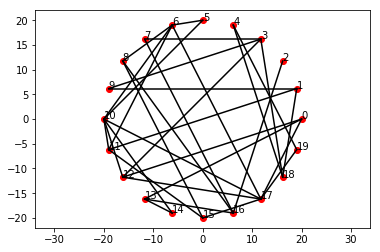

In [27]:
plotGraph(A, pA)

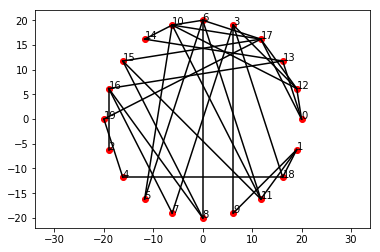

In [29]:
plotGraphReordered(B, pA, bijectAB)

In [30]:
# Use the refined graph with th GA
A = B
dA= dB

In [ ]:
# Genetic ALgorithm

NbIndiv = 100
NbGen = 2000


In [ ]:
# Create a population
pop = []
for i in range(NbIndiv):
    pop.append(createPosRandom(N, D))

In [ ]:
# Apply GA
for gen in tqdm(range(NbGen)):
    # Create the new population
    child = []
    
    # CrossOver
    # create proba of each indiv
    # roulette wheel selection
    sorted(pop, key=  lambda x:S(x, dA))
    
    pIndiv = [S(pop[i], dA) for i in range(NbIndiv)]
    pTot = np.sum(pIndiv)
    pIndiv /= pTot
    
    for c in range(int(NbIndiv/2)):
        [i1, i2] = np.random.choice(NbIndiv, 2, replace=False, p=pIndiv)
        [i1, i2] = np.random.choice(20, 2, replace=False)
        p1 = pop[i1]
        p2 = pop[i2]
        
        #Select a point to do the splitting
        children = createPos(N, D)
        split = np.random.randint(N)
        
        # Children 0
        children[:split, :] = p1[:split, :]
        children[split:, :] = p2[split:, :]
        if (np.random.uniform() < .01):
            #print(createPointRandom(N, D))
            #print(children[:, np.random.randint(N)])
            children[np.random.randint(N), :]= createPointRandom(N, D)
        if (np.random.uniform() < .01):
            pA = opti2_GA(A, N, D, 1000, pA)
            
        child.append(children)
        # Children 1
        children = createPos(N, D)
        children[:split, :] = p2[:split, :]
        children[split:, :] = p1[split:, :]
        if (np.random.uniform() < .01):
            children[np.random.randint(N), :]= createPointRandom(N, D)
        child.append(children)
    pop, child = child, pop
    

In [ ]:
findBestIndiv(pop)

In [ ]:
pA = pop[findBestIndiv(pop)]
plotGraph(B, pA)
S(pA, dA)


  1%|▏         | 72/5000 [00:01<01:41, 48.64it/s]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/admin/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/admin/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/admin/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 5000/5000 [01:46<00:00, 47.02it/s]


344.3504819866634

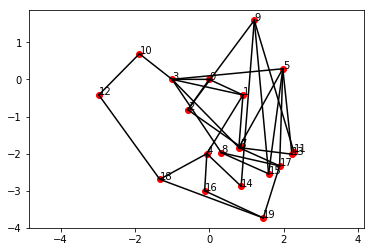

In [31]:
pA = opti_localSearch(A, N, D, 5000)
S(pA, dA)

100%|██████████| 50000/50000 [00:55<00:00, 899.38it/s]


116.5751530463007

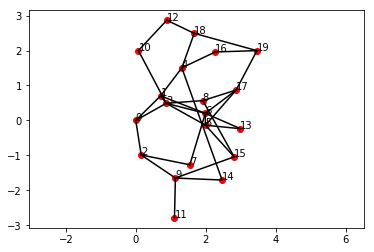

In [33]:
pA = opti_localSearchRefined(A, N, D, 50000)
S(pA, dA)